Target- 452


Text(0.5, 1.0, 'Target-452')

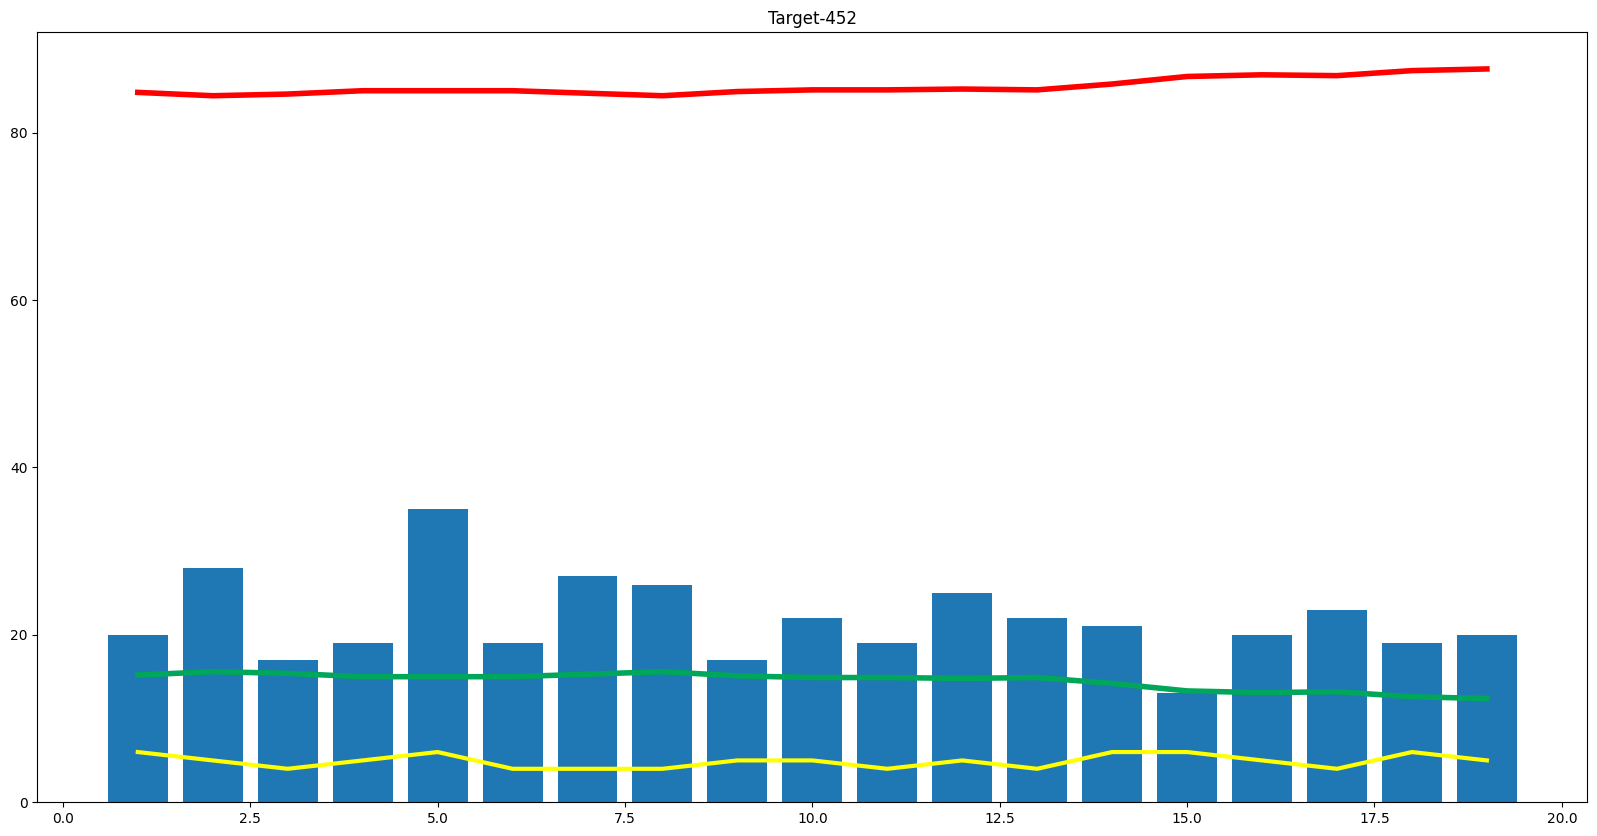

In [2]:
import numpy as np
import pandas as pd

match = pd.read_csv("BPL_dataset_1.csv")
delivery = pd.read_csv("BPL_deliveries_dataset_2.csv")

total_score_df = delivery.groupby(['match_id','inning']).sum()['total_runs'].reset_index()

total_score_df = total_score_df[total_score_df['inning']==1]
match_df = match.merge(total_score_df[['match_id','total_runs']],left_on='id',right_on='match_id')

teams =[
    'Khulna Tigers',
    'Rangpur Riders',
    'Barishal Bulls',
    'Sylhet Strikers',
    'Rajshahi Kings',
    'Dhaka Dominators',
    'Comilla Victorians',
    'Chattogram Challengers']

match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]

match_df = match_df[['match_id','city','winner','total_runs']]
delivery_df = match_df.merge(delivery,on='match_id')

delivery_df = delivery_df[delivery_df['inning']==2]
delivery_df['city'].unique()

delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()

delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']
delivery_df['balls_left'] = 126 - (delivery_df['over']*6 + delivery_df['ball'])

delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x:x if x=="0" else "1")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype('int')
wickets = delivery_df.groupby('match_id')['player_dismissed'].cumsum().values
delivery_df['wickets'] = 10 - wickets
delivery_df.head(20)

#crr(current run rate) = curren runs/ overs(balls)
#rrr(required run rate) = runs left / balls left
delivery_df['crr'] = (delivery_df['current_score']*6) / (120 - delivery_df['balls_left'])
delivery_df['rrr'] = (delivery_df['runs_left']*6) / ( delivery_df['balls_left'])

def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0
delivery_df['result'] = delivery_df.apply(result,axis=1)

final_df =  delivery_df[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr','result']]
final_df = final_df.sample(final_df.shape[0])

final_df.dropna(inplace=True)
final_df.isnull().sum()
final_df = final_df[final_df['balls_left']!=0]

x = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
trf = ColumnTransformer([('trf',OneHotEncoder(sparse_output=False,drop='first'),['batting_team','bowling_team','city'])],remainder='passthrough')

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline(steps=[
    ('step1',trf),
    ('step2',LogisticRegression(solver='liblinear'))
])

pipe.fit(x_train,y_train)

y_pred = pipe.predict(x_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)
import numpy as np
def match_progression(x_df, match_id, pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets', 'total_runs_x', 'crr', 'rrr']]
    temp_df = temp_df[temp_df['balls_left'] != 0]

    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0] * 100, 1)
    temp_df['win'] = np.round(result.T[1] * 100, 1)
    temp_df['end_of_over'] = range(1, temp_df.shape[0] + 1)

    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0, target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)

    # Calculate wickets fallen in each over
    wickets = list(temp_df['wickets'].values)
    #modify wickets
    new_wickets = wickets[:]
    new_wickets.insert(0, 10)

    wickets.append(0)
    wickets = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - wickets)[:temp_df.shape[0]]
    print("Target-", target)
    temp_df = temp_df[['end_of_over', 'runs_after_over', 'wickets_in_over', 'lose', 'win']]
    return temp_df, target


temp_df, target = match_progression(delivery_df, 1, pipe)

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))






In [3]:
y_pred = pipe.predict(x_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8631827731092437

In [4]:
import joblib
joblib.dump(pipe, "model_pipeline.pkl")


['model_pipeline.pkl']